In [25]:
import json
import os

import chromadb
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from openai import OpenAI
from chromadb import Documents, EmbeddingFunction, Embeddings
from sentence_transformers import SentenceTransformer
from chromadb.utils import embedding_functions
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [19]:
# https://docs.trychroma.com/guides
CHROMA_DATA_PATH = "chroma_data"
# CHROMA_DATA_PATH = r"C:\Users\ihett\OneDrive\Gabrilyi\arxiv_project\chroma_data"

PARQUET_PATH = '../data/arxiv_metadata_sample.parquet.gzip'
# PARQUET_PATH = r"C:\Users\ihett\OneDrive\Gabrilyi\arxiv_project\arxiv_metadata_sample.parquet.gzip"

# [WARNING]
# Choose whether to delete all chroma data for the chosen model and recompute it
#
DO_DELETE_CHROMA_DATA = True

#
# Choose model style [sentence_transformers, lmstudio]
#
model_style = "sentence_transformers"


#
# Models from LMStudio
#
# EMBED_MODEL = "gte-small-gguf" # LMStudio (ChristianAzinn/gte-small-gguf/gte-small.Q4_0.gguf)


#
# Models from Sentence Transformers (https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)
#
# EMBED_MODEL = "all-MiniLM-L12-v2"
# EMBED_MODEL = "all-mpnet-base-v2"
# https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/semantic-search/semantic_search_publications.py
EMBED_MODEL = "allenai-specter" # https://huggingface.co/sentence-transformers/allenai-specter
# EMBED_MODEL = "GIST-small-Embedding-v0" # https://huggingface.co/avsolatorio/GIST-small-Embedding-v0


COLLECTION_NAME = "arxiv_papers"
BATCH_SIZE = 2000

CHROMA_DATA_PATH = os.path.join(CHROMA_DATA_PATH, EMBED_MODEL)

In [20]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

arxiv_df = pd.read_parquet(PARQUET_PATH)
arxiv_df = arxiv_df.sample(20000)

print(arxiv_df.shape)

(20000, 13)


In [21]:
def text_processing(sample):
    title = sample['title']
    abstract = sample['abstract']

    # remove special characters
    title = title.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    abstract = abstract.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # remove multiple spaces
    title = ' '.join(title.split())
    abstract = ' '.join(abstract.split())

    return f"{title}[SEP]{abstract}"

In [22]:
arxiv_df['text'] = arxiv_df.apply(text_processing, axis=1)
arxiv_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,super_category,amount_super_categories,text
9036,2201.01003,Aligning Domain-specific Distribution and Clas...,While Unsupervised Domain Adaptation (UDA) a...,"[cs.LG, cs.AI, cs.CV]",2022-01-05,11,209,"[Machine Learning, Artificial Intelligence, Co...",3,2022,"[Computer Science, Computer Science, Computer ...",Computer Science,1,Aligning Domain-specific Distribution and Clas...
21241,2109.13059,Trans-Encoder: Unsupervised sentence-pair mode...,"In NLP, a large volume of tasks involve pair...","[cs.CL, cs.AI, cs.LG]",2022-03-15,8,222,"[Computation and Language, Artificial Intellig...",3,2022,"[Computer Science, Computer Science, Computer ...",Computer Science,1,Trans-Encoder: Unsupervised sentence-pair mode...
148410,1504.00327,Mortality cohort effect detection and measurem...,This paper analyzes mortality cohort effect ...,[stat.AP],2015-04-03,10,97,[Applications],1,2015,[Statistics],Statistics,1,Mortality cohort effect detection and measurem...


In [23]:
def create_metadatas(arxiv_df):
    metadatas = []
    for _, row in arxiv_df.iterrows():
        metadatas.append({
            "update_date": row['update_date'],
            "title_words": row['title_words'],
            "abstract_words": row['abstract_words'],
            "super_category": row['super_category'],
            "mapped_categories": ";".join(row['mapped_categories']),
        })

    return metadatas

In [26]:
def create_collection(client, collection_name, embedding_function):
    collection = client.create_collection(
        name=collection_name,
        embedding_function=embedding_function,
        metadata={"hnsw:space": "cosine"},
        get_or_create=True,
    )

    return collection

def delete_collection_data(client, collection, collection_name):
    print(f"Deleting data from collection {collection_name} with {collection.count()} documents")
    client.delete_collection(collection_name)

def get_random_samples_from_collection(collection, n_samples):
    collection_ids = collection.get()["ids"]
    random_ids = np.random.choice(collection_ids, n_samples, replace=False).tolist()
    documents = collection.get(ids=random_ids)
    return documents

def upsert_data(collection, arxiv_df, metadatas, batch_size):
    for i in tqdm(range(0, len(arxiv_df), batch_size)):
        collection.upsert(
            documents=arxiv_df['text'].iloc[i:i + batch_size].tolist(),
            ids=arxiv_df['id'].iloc[i:i + batch_size].tolist(),
            metadatas=metadatas[i:i + batch_size],
        )

In [27]:
if model_style == "sentence_transformers":
    embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name=EMBED_MODEL,
        device="cuda",
        cache_folder=cache_dir
    )
elif model_style == "lmstudio":
    class Embedder(EmbeddingFunction):
        def __init__(self):
            self.client = OpenAI(base_url="http://localhost:5000/v1", api_key="lm-studio")
            self.model = EMBED_MODEL

        def __call__(self, input:Documents) -> Embeddings:
            return [d.embedding for d in self.client.embeddings.create(input = input, model=self.model).data]

    embedding_func = Embedder()

w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
# delete the collection if it exists
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

collection = create_collection(client, COLLECTION_NAME, embedding_func)

########################################
######## WARNING: DELETES DATA #########
########################################
if DO_DELETE_CHROMA_DATA and input("Do you want to delete all data in the collection? (y/n): ") == "y":
    ##### delete if you want to start fresh but then you need to create the collection again
    delete_collection_data(client, collection, COLLECTION_NAME)
    collection = create_collection(client, COLLECTION_NAME, embedding_func)

    ##### create metadatas
    metadatas = create_metadatas(arxiv_df)

    ##### upsert data (insert or update if exists)
    upsert_data(collection, arxiv_df, metadatas, BATCH_SIZE)

Deleting data from collection arxiv_papers with 119503 documents


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
# Define query
words_per_line = 10
# define papers to show
top_n_papers = 3

# query = "Multimodal foundation models for zero-shot animal species recognition in camera trap images; fine-tuning vision-language models for expert-like captions; efficient wildlife monitoring with reduced labor requirements."
query = "Zero-shot species recognition in camera trap images using multimodal models"
# query = "Song embedding representation for similarity search for songs"
# query = "Title: If deep learning is the answer, then what is the question? - Abstract: Neuroscience research is undergoing a minor revolution. Recent advances in machine learning and artificial intelligence (AI) research have opened up new ways of thinking about neural computation. Many researchers are excited by the possibility that deep neural networks may offer theories of perception, cognition and action for biological brains. This perspective has the potential to radically reshape our approach to understanding neural systems, because the computations performed by deep networks are learned from experience, not endowed by the researcher. If so, how can neuroscientists use deep networks to model and understand biological brains? What is the outlook for neuroscientists who seek to characterise computations or neural codes, or who wish to understand perception, attention, memory, and executive functions? In this Perspective, our goal is to offer a roadmap for systems neuroscience research in the age of deep learning. We discuss the conceptual and methodological challenges of comparing behaviour, learning dynamics, and neural representation in artificial and biological systems. We highlight new research questions that have emerged for neuroscience as a direct consequence of recent advances in machine learning."

# delete random 20% random words
# query_words = query.split()
# n_words_to_delete = int(len(query_words) * 0.7)
# query_words = np.random.choice(query_words, len(query_words) - n_words_to_delete, replace=False)
# # shuffle the words
# np.random.shuffle(query_words)
# query = " ".join(query_words)

print("Query:\n", query, "\n")
query_results = collection.query(query_texts=[query], n_results=top_n_papers)
for _id, _doc, _dist, _meta in zip(query_results["ids"][0], query_results["documents"][0], query_results["distances"][0], query_results["metadatas"][0]):
    print(f"#####   ID: {_id}   #####")
    print(f"Distance: {_dist}")
    print(f"Metadata: {_meta}")
    print(f"Document:")
    print(_doc)
    # _doc_lines = _doc.split()
    # for i in range(0, len(_doc_lines), words_per_line):
    #     print(" ".join(_doc_lines[i:i + words_per_line]))
    print("\n")

Query:
 Zero-shot species recognition in camera trap images using multimodal models 

#####   ID: 2107.08743   #####
Distance: 0.20956987142562866
Metadata: {'abstract_words': 161, 'mapped_categories': 'Quantitative Methods', 'super_category': 'Quantitative Biology', 'title_words': 7, 'update_date': '2021-07-20'}
Document:
Characterising mosquito biting behaviour at high resolution[SEP]Blood feeding represents a critical event in the life cycle of female mosquitoes. In addition to providing nutrients to the mosquito, blood feeding facilitates the transmission of parasites and viruses to hosts, potentially having devastating health consequences. Despite this, our understanding of these short, yet important bouts of behaviour is incomplete. How and where a mosquito decides to feed and the success of feeding can influence the transmission of pathogens, while a more thorough understanding may allow interventions to reduce or prevent infections. Recent advances in machine vision and automat

In [30]:
response = collection.get(include=["metadatas", "documents", "embeddings"])
df = pd.DataFrame({
    "id": response["ids"],
    "document": response["documents"],
    "embedding": response["embeddings"],
    "super_category": [x["super_category"] for x in response["metadatas"]],
})
# all_categories = df["categories"].explode().unique()
all_categories = df["super_category"].unique()
cat_mapping = {cat: i for i, cat in enumerate(all_categories)}
df["cat_id"] = df["super_category"].apply(lambda x: cat_mapping[x])
# df.loc[:, all_categories] = df["super_category"].apply(lambda x: [1 if cat in x else 0 for cat in all_categories]).tolist()
df.head(3)

,id,document,embedding,super_category,cat_id
0,1001.02,How many Laplace transforms of probability mea...,"[-0.23298165202140808, 0.761928141117096, 0.00...",Statistics,0
1,1001.0272,Strong interaction studies with PANDA[SEP]The ...,"[-0.5057349801063538, 0.2418287694454193, 0.18...",Physics,1
2,1001.0415,A new Rational Generating Function for the Fro...,"[-0.28493988513946533, -0.09567784518003464, -...",Computer Science,2


In [31]:
from renumics import spotlight

spotlight.show(df)

# Simple Classification Head

In [33]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class EmbeddingDataset(Dataset):
    def __init__(self, df, cat_ids):
        self.ids = df["id"].values
        self.embeddings = torch.tensor(df["embedding"].tolist(), dtype=torch.float32)
        self.categories = torch.tensor(df["cat_id"].values, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.embeddings[idx], self.categories[idx]

class EmbeddingModel(torch.nn.Module):
    def __init__(self, n_emb_size, n_categories):
        super(EmbeddingModel, self).__init__()
        self.fc1 = torch.nn.Linear(n_emb_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, n_categories)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# train val split
emb_dataset = EmbeddingDataset(df, cat_mapping)
train_size = int(0.8 * len(emb_dataset))
val_size = len(emb_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(emb_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingModel(len(df["embedding"].values[0]), len(all_categories)).to(device)

Train size: 16000
Val size: 4000


In [35]:
def train(model, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for _, emb, cat in train_loader:
            emb, cat = emb.to(device), cat.to(device)
            optimizer.zero_grad()
            output = model(emb)
            loss = criterion(output, cat)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for _, emb, cat in val_loader:
                emb, cat = emb.to(device), cat.to(device)
                output = model(emb)
                _, predicted = torch.max(output.data, 1)
                total += cat.size(0)
                correct += (predicted == cat).sum().item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {100 * correct / total}")

train(model, train_loader, val_loader, epochs=10)

Epoch 1/10, Loss: 0.1502884179353714, Accuracy: 87.375
Epoch 2/10, Loss: 0.2534046769142151, Accuracy: 87.8
Epoch 3/10, Loss: 0.17684942483901978, Accuracy: 87.75
Epoch 4/10, Loss: 0.11285049468278885, Accuracy: 88.425
Epoch 5/10, Loss: 0.20280574262142181, Accuracy: 88.825
Epoch 6/10, Loss: 0.2330324351787567, Accuracy: 88.475
Epoch 7/10, Loss: 0.2378999888896942, Accuracy: 89.05
Epoch 8/10, Loss: 0.26745402812957764, Accuracy: 89.475
Epoch 9/10, Loss: 0.23537755012512207, Accuracy: 89.375
Epoch 10/10, Loss: 0.4189385175704956, Accuracy: 89.3


# cluster

In [36]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

num_classes = len(cat_mapping)
print(f"Number of classes: {num_classes}")
# arxiv_df['class'] = arxiv_df['super_category'].apply(lambda x: cat_mapping[x])
df['class'] = df['super_category'].apply(lambda x: cat_mapping[x])
p_per_class = 1
# only use p_per_class percent of each class
sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class, random_state=42)).reset_index(drop=True)
print(f"Sampled data shape: {sampled_df.shape}")

Number of classes: 7
Sampled data shape: (20000, 6)


C:\Users\gabri\AppData\Local\Temp\ipykernel_15208\1386924412.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class, random_state=42)).reset_index(drop=True)


In [106]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Normalizing the data
embedding_data = np.array(sampled_df["embedding"].tolist())
# scaler = StandardScaler()
# embedding_data_scaled = scaler.fit_transform(embedding_data)

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=.1, n_components=2)
umap_embeddings = umap_model.fit_transform(embedding_data)
projected_embeddings = pd.DataFrame(data=umap_embeddings, columns=["comp1", "comp2"])

# PCA
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(embedding_data)
# projected_embeddings = pd.DataFrame(data=pca_result, columns=["comp1", "comp2"])

# TSNE
# tsne = TSNE(n_components=2)
# tsne_result = tsne.fit_transform(embedding_data)
# projected_embeddings = pd.DataFrame(data=tsne_result, columns=["comp1", "comp2"])

# K-Means Clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans_labels = kmeans.fit_predict(projected_embeddings)

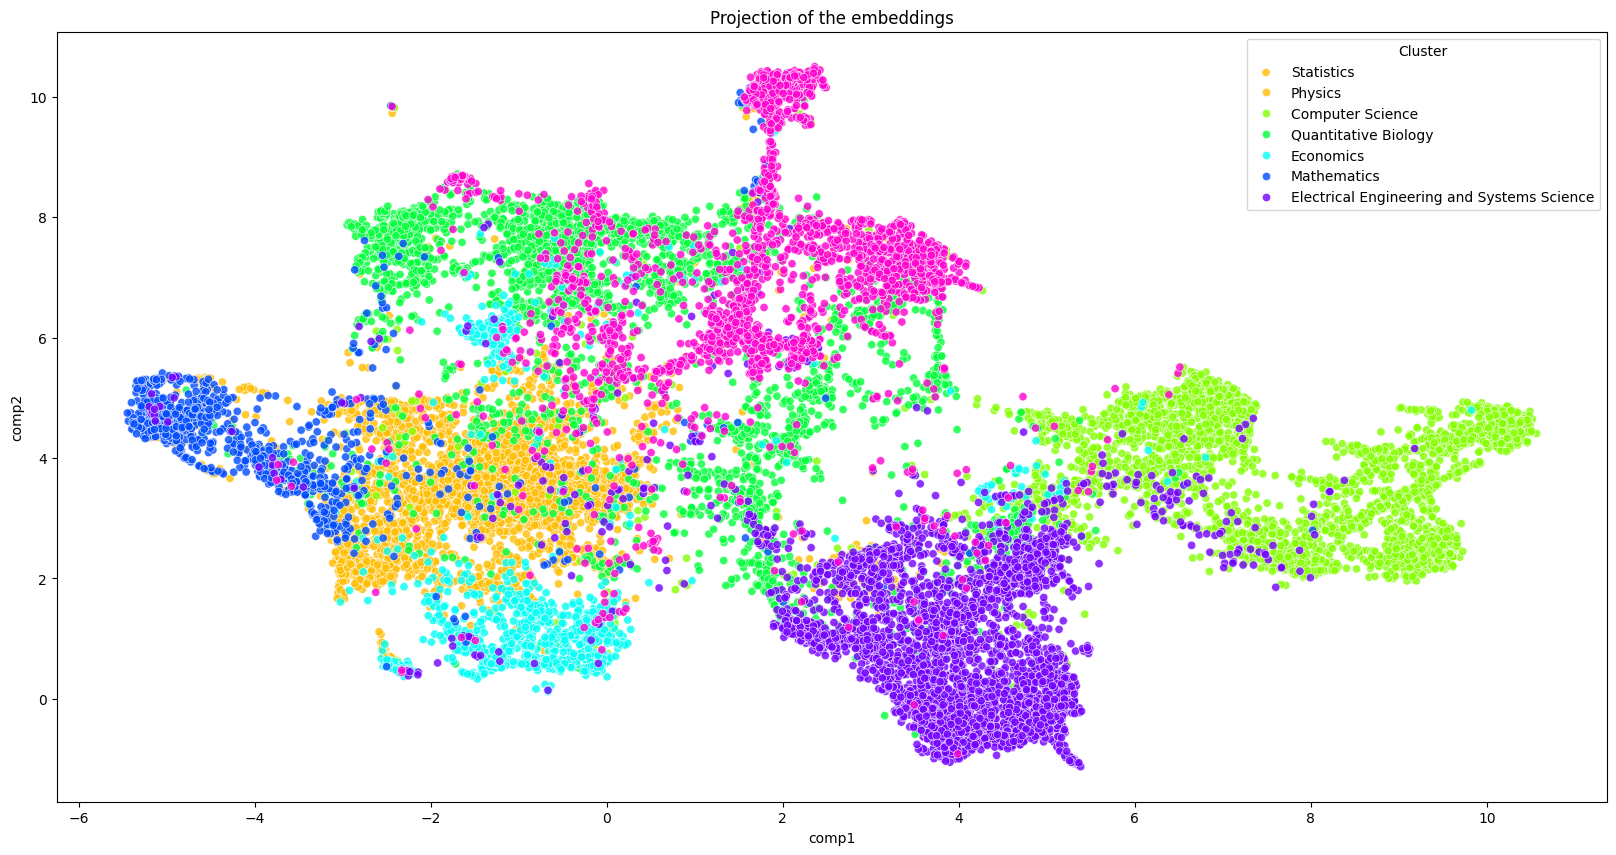

In [107]:
# visualize
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=projected_embeddings["comp1"], y=projected_embeddings["comp2"],
    hue="class",
    palette=sns.color_palette("hsv", num_classes),
    data=sampled_df,
    legend="full",
    alpha=0.8
)

plt.title("Projection of the embeddings")
# Add cluster names from df["super_category"]
plt.legend(title="Cluster", loc="upper right", labels=all_categories)
plt.show()

In [108]:
import plotly.express as px

# Create a dataframe for plotly
plot_df = projected_embeddings.copy()
plot_df["Ground Truth"] = sampled_df["super_category"]
plot_df["Class"] = kmeans_labels

# Define markers for actual classes
markers = [
    "circle",
    "square",
    "triangle-up",
    "diamond",
    "triangle-down",
    "triangle-left",
    "triangle-right",
    "pentagon",
    "star",
    "hexagon",
]

# Create a new column for marker shapes
plot_df["Marker"] = plot_df["Class"].apply(lambda x: markers[x % len(markers)])

# Plot using plotly
fig = px.scatter(
    plot_df,
    x="comp1",
    y="comp2",
    color="Ground Truth",
    symbol="Marker",
    title="UMAP embeddings colored by actual category and shaped by kmeans classes",
    symbol_map={str(i): marker for i, marker in enumerate(markers)},
    width=1800,
    height=1080,
    labels={"Ground Truth": "Actual Category"},
)

fig.update_traces(marker=dict(size=6))  # Adjust the marker size
# remove marker from legend
fig.update_traces(showlegend=True)
fig.show()

In [89]:
# calculate accuracy
def calculate_accuracy(df, kmeans_labels, cat_mapping):
    df["kmeans_labels"] = kmeans_labels
    correct = 0
    total = 0
    for cat, kmeans_label in zip(df["cat_id"], df["kmeans_labels"]):
        if cat == kmeans_label:
            correct += 1
        total += 1

    return correct / total

accuracy = calculate_accuracy(sampled_df, kmeans_labels, cat_mapping)
print(f"Accuracy: {accuracy}")

Accuracy: 0.037


In [90]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

embeddings_to_eval = sampled_df["embedding"].tolist().copy()
# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_to_eval)

accuracy = calculate_accuracy(sampled_df, cluster_labels, cat_mapping)
print(f"Accuracy: {accuracy:.4f}")

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(sampled_df["super_category"], cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(sampled_df["super_category"], cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Silhouette Score
silhouette_avg = silhouette_score(embeddings_to_eval, sampled_df["super_category"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Accuracy: 0.0366
Adjusted Rand Index (ARI): 0.4633
Normalized Mutual Information (NMI): 0.5248
Silhouette Score: 0.0405
